# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
from sklearn.metrics import classification_report, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

!pip install owlready2
!pip install anytree

from anytree import AnyNode, Node, RenderTree

from owlready2 import set_render_func
from owlready2 import get_ontology
from owlready2 import default_world

#Set Seeds
seed = 42
np.random.seed(seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 22.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for owlready2: filename=owlready2-0.47-cp310-cp310-linux_x86_64.whl size=24075198 sha256=a44940de9fd835911eb3f45c4bcfad79002d826116d09a355a33b0dfff07ea16
  Stored in directory: /root/.cache/pip/wheels/27/3e/ba/4171c4b10bba9fe1774fbf8fcf794de889e636ce64ad83a533
Successfully built owlready2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.8 MB/s eta 0:00:00


In [4]:
#Connect to drive to import files
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/gdrive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data and Preprocess

In [5]:
#Get the OWL/Protege ontology which encodes neuroanatomical structral information
onto = get_ontology("/content/drive/My Drive/ontology/tree-structure-brain-anatomy-FastSurfer-v2.rdf").load()


# Create an empty tree,
# to later represent the parent-child relationships amongst ROIs and easily traverse amongst them
root = Node("root", ontoClass=onto.Brain_Region)


#For pretty printing of the entitiy names
def render_using_label(entity):
    return entity.label.first() or entity.name
set_render_func(render_using_label)


#A function takes an ontology 'onto' object and a list of lobe names 'lobe_name' (parent ROI names),
# and returns the names of all leaf and non-leaf brain regions that are descendants of the specified lobes.
def find_lobe_children_ROI(onto, lobe_name):
  result = []  #includes leaf and non-leaf children on a parent node
  for region in onto.Brain_Region.descendants(include_self=True):
      with onto:
        if len(region.descendants(include_self=False))==0:  # leaf node
          pass
        else:
          if region.name in lobe_name:
            result = result + [leaf_ROI_obj.name for leaf_ROI_obj in region.descendants(include_self=True)]
  return result

In [28]:
Temporal_Lobe  = ['Left_Temporal_Lobe','Right_Temporal_Lobe']
Frontal_Lobe   = ['Left_Frontal_Lobe','Right_Frontal_Lobe']
Parietal_Lobe  = ['Left_Parietal_Lobe','Right_Parietal_Lobe']
Occipital_Lobe = ['Left_Occipital_Lobe','Right_Occipital_Lobe']
Cerebrum = ['Cerebrum']
Cerebellum = ['Cerebellum']
Whole_brain = ['Brain_Region']
Cerebrospinal_Fluid = ['Cerebrospinal_Fluid']
Hippocampus = ['Right_Hippocampus','Left_Hippocampus']
Amygdala = ['Right_Amygdala','Left_Amygdala']

#For ex., here i chose to only include the Frontal and Temporal lobe regions
child_ROIs = find_lobe_children_ROI(onto, Frontal_Lobe) + find_lobe_children_ROI(onto, Temporal_Lobe)

# OR for ex., here i chose to include the full brain
#child_ROIs = find_lobe_children_ROI(onto, Whole_brain)

#child_ROIs = Amygdala  #Hippocampus
ROIs_chosen = child_ROIs

In [29]:
#Load the data frames with w-scores values for each ROI for all the samples in the study
all_samples_vol_w = pd.read_csv('/content/drive/My Drive/ontology/wscore_AllCohorts_AllStages.csv', index_col=False)
all_samples_thickness_w = pd.read_csv('/content/drive/My Drive/ontology/ThickAvg_w-scores.csv', index_col=False)
all_samples_sufaceArea_w = pd.read_csv('/content/drive/My Drive/ontology/SurfArea_w-scores.csv', index_col=False)

In [ ]:
print(all_samples_vol_w.shape)                                      #Book-keeping
print(np.unique(all_samples_vol_w.grp, return_counts=True))

In [ ]:
ROI_list = all_samples_vol_w.columns[10:].to_list()


## other functionalities

In [32]:
def return_label(df_sim):                     #A function for binarizing/thresholding the DSI
  label_pred = []
  for i in range(len(df_sim)):
    if df_sim.iloc[i]["DSI"]>0:
      label_pred.append('AD')
    else:
      label_pred.append('bvFTD')

  return label_pred

In [13]:
def AUC(fpr, tpr, fold):
  roc_auc = auc(fpr, tpr)

  fig = plt.figure()
  plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  # plt.show()

  fig.savefig('Fold{}_AUC.png'.format(fold), dpi=fig.dpi)
  return roc_auc

In [14]:
def get_values(conf_matrix):
    # Given a model's confusion matrix of shape 2x2, return evaluation metrics
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((ppv * sen) / (ppv + sen))
    bacc = (spec + sen) / 2
    acc = (tp+tn)/(tp+tn+fp+fn)
    return bacc, sen, spec, ppv, npv, f1, acc

# 10-fold Cross Validation of the DSI metric

In [33]:
ROI_list = ROIs_chosen

In [34]:
all_samples_vol_w['sample_'] =  all_samples_vol_w['sample'].str.replace('ADNI2/GO', 'ADNI')
all_samples_vol_w['sample_'] =  all_samples_vol_w['sample_'].str.replace('ADNI3', 'ADNI')
all_samples_vol_w['fullsid'] =  all_samples_vol_w['sid'] + '_' + all_samples_vol_w['sample_']

sample_w_multi = pd.merge( all_samples_vol_w, all_samples_thickness_w, on='fullsid', suffixes=('_vol','_tkn'))
sample_w_multi.dropna(axis=1, how='all', inplace=True)
sample_w_multi.shape

#empty subcortical measures for thickness ans surface area
temp_ = ['3rd-Ventricle_tkn', '4th-Ventricle_tkn', 'Brainstem_tkn', 'Anterior_tkn', 'Central_tkn', 'Mid_Anterior_tkn', 'Mid_Posterior_tkn', 'Posterior_tkn', 'CSF_tkn', 'Left_Nucleus_Accumbens_tkn', 'Left_Amygdala_tkn', 'Left_Caudate_Nucleus_tkn', 'Left_Cerebellum_Cortex_tkn', 'Left_Cerebellum_White_Matter_tkn', 'Left_Cerebral_White_Matter_tkn', 'Left_Choroid_Plexus_tkn', 'Left_Hippocampus_tkn', 'Left_Inf-Lat-Vent_tkn', 'Left_Lateral_Ventricle_tkn', 'Left_Pallidum_tkn', 'Left_Putamen_tkn', 'Left_Thalamus_tkn', 'Left_Ventral_Diencephalon_tkn', 'Right_Nucleus_Accumbens_tkn', 'Right_Amygdala_tkn', 'Right_Caudate_Nucleus_tkn', 'Right_Cerebellum_Cortex_tkn', 'Right_Cerebellum_White_Matter_tkn', 'Right_Cerebral_White_Matter_tkn', 'Right_Choroid_Plexus_tkn', 'Right_Hippocampus_tkn', 'Right_Inf-Lat-Vent_tkn', 'Right_Lateral_Ventricle_tkn', 'Right_Pallidum_tkn', 'Right_Putamen_tkn', 'Right_Thalamus_tkn', 'Right_Ventral_Diencephalon_tkn', 'WM_Hypointensities_tkn', 'Corpus_Callosum_tkn', 'White_Matter_tkn', 'Cerebrospinal_Fluid_tkn', 'Left_Basal_Ganglia_tkn', 'Cerebellum_tkn', 'Left_Cerebellum_tkn', 'Left_Diencephalon_tkn', 'Right_Basal_Ganglia_tkn', 'Right_Cerebellum_tkn', 'Right_Diencephalon_tkn']

ROI_list_vol = [ele+'_vol' for ele in ROI_list]
ROI_list_thickness = list(set([ele+'_tkn' for ele in ROI_list]) - set(temp_))

#Here we chose to use both the volumetry and cortical thickness signals
ROI_list_ = ROI_list_vol + ROI_list_thickness


columns = ['Stage'] + ROI_list_

In [35]:
# A dataframe to hold the evaluation metrics from each fold
df_fold_metrics = pd.DataFrame(columns=['fold', 'auc', 'bacc', 'sen', 'spec', 'ppv', 'npv', 'f1', 'acc'])

Fold 0:
15
[[38 13]
 [ 1 11]]
Fold 1:


<ipython-input-36-08f20f61032f>:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_fold_metrics = pd.concat([df_fold_metrics, row.to_frame().T], ignore_index=True)


9
[[43  8]
 [ 2 10]]
Fold 2:
14
[[42  9]
 [ 1 11]]
Fold 3:
14
[[43  7]
 [ 5  8]]
Fold 4:
15
[[42  8]
 [ 5  8]]
Fold 5:
16
[[42  8]
 [ 3 10]]
Fold 6:
12
[[39 11]
 [ 1 12]]
Fold 7:
23
[[35 15]
 [ 4  9]]
Fold 8:
14
[[44  6]
 [ 5  8]]
Fold 9:
22
[[37 13]
 [ 5  8]]


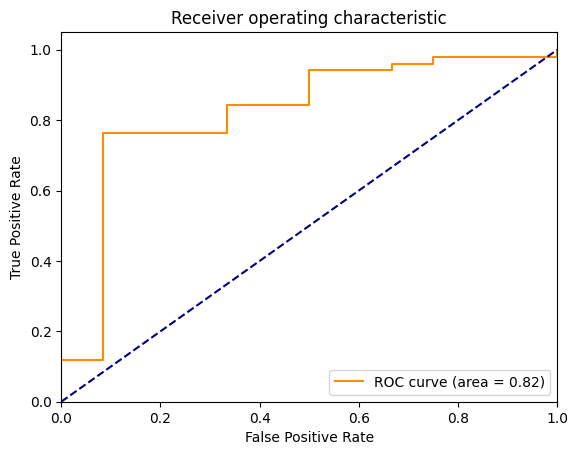

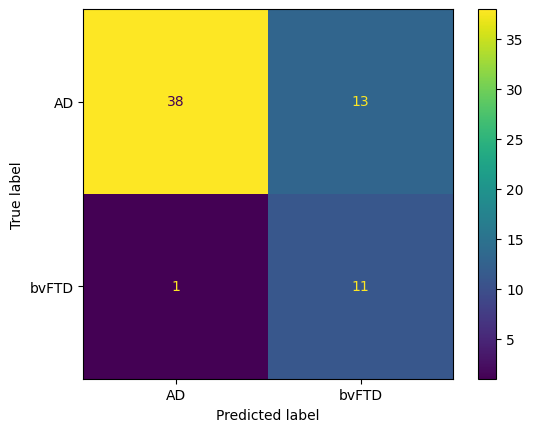

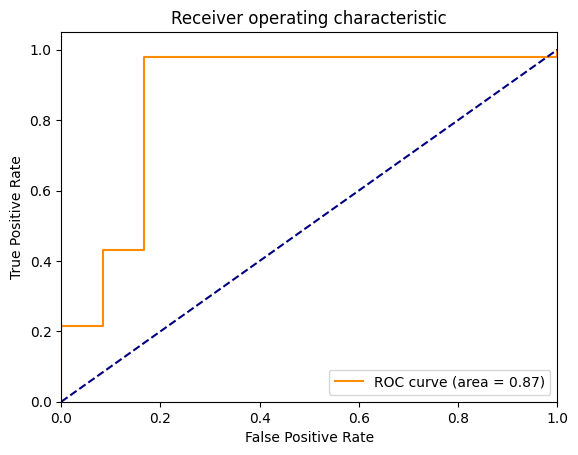

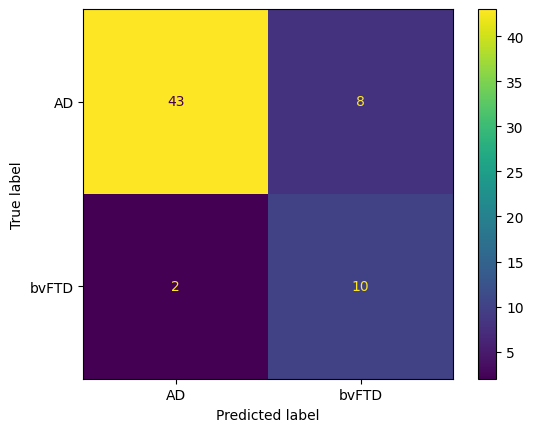

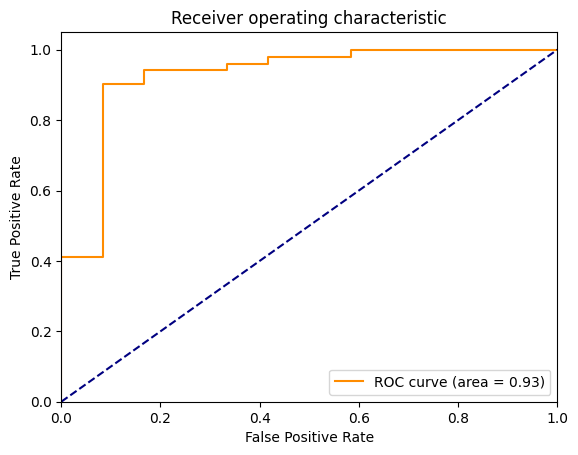

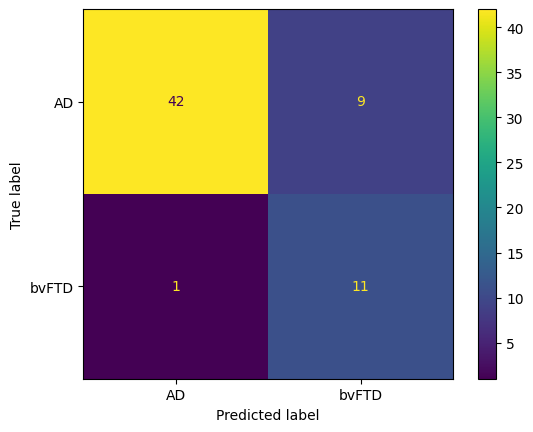

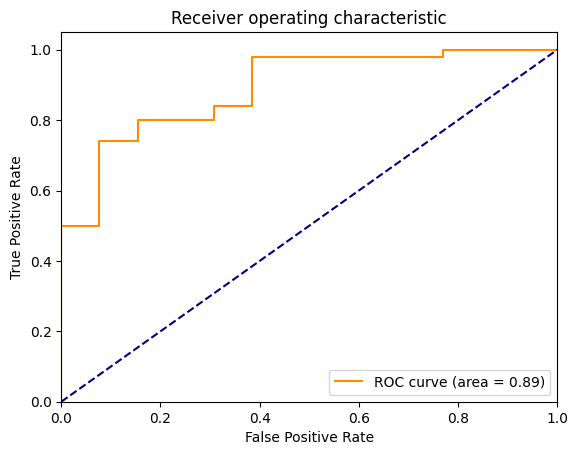

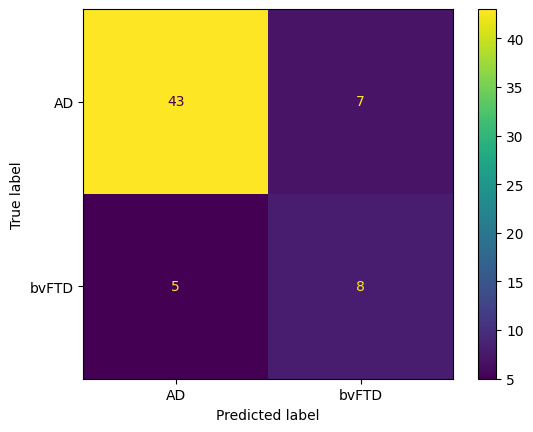

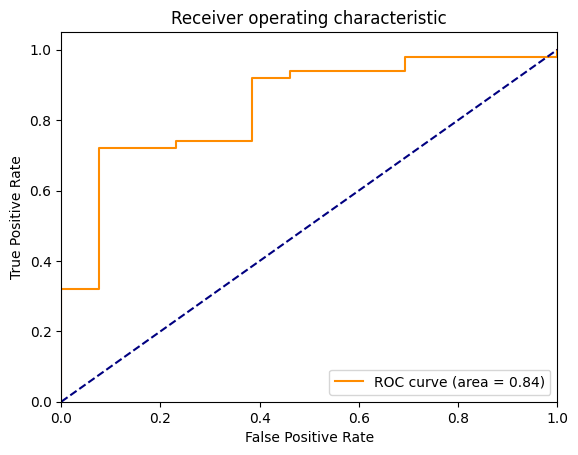

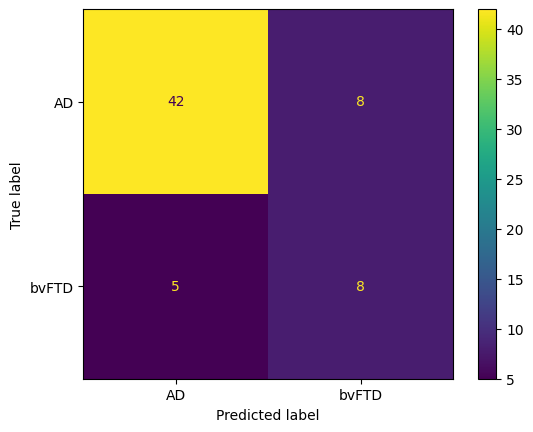

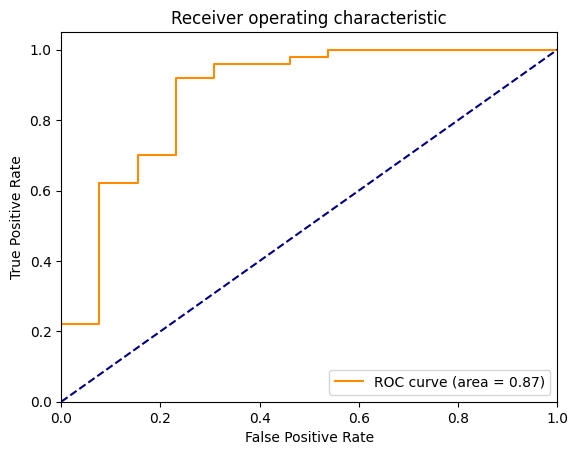

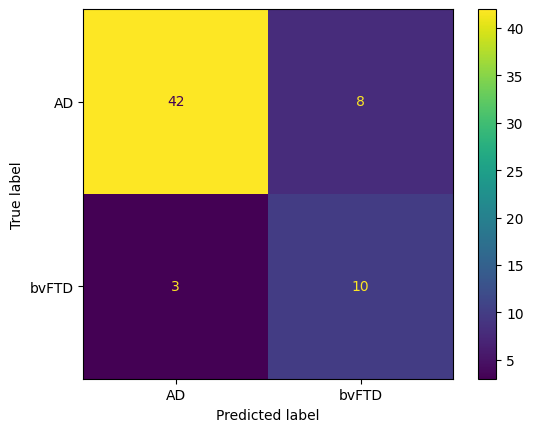

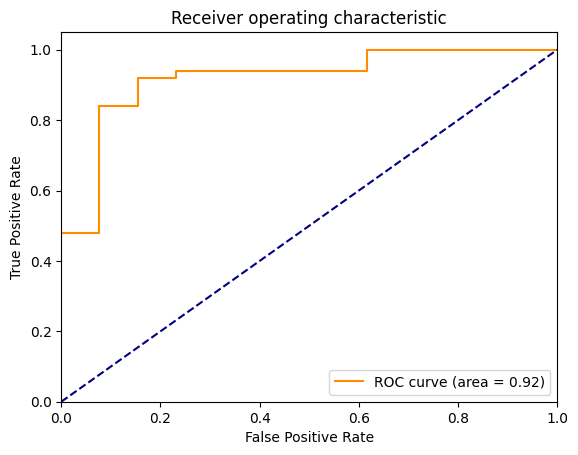

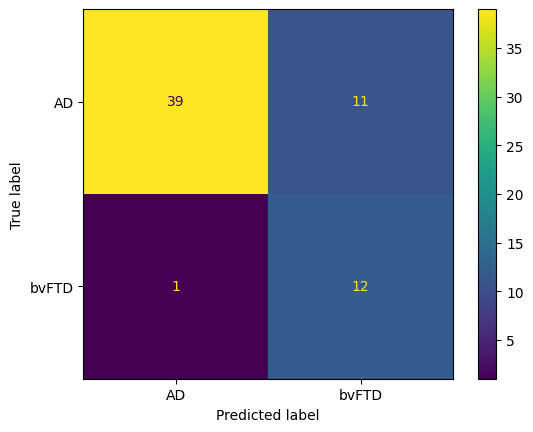

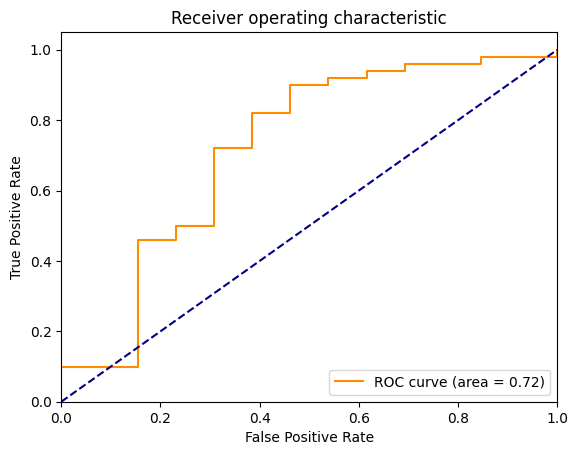

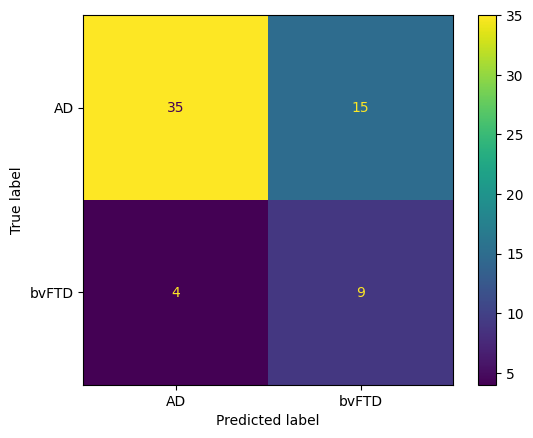

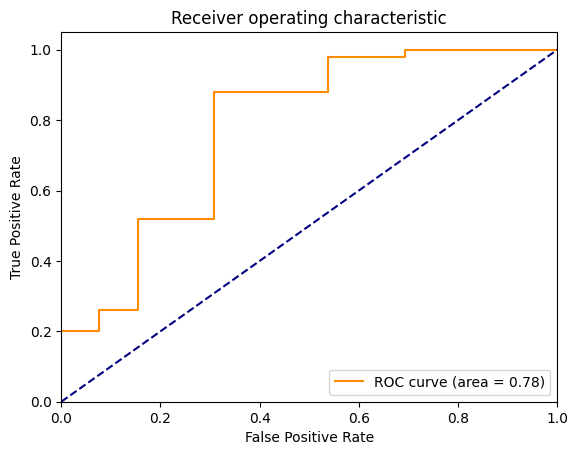

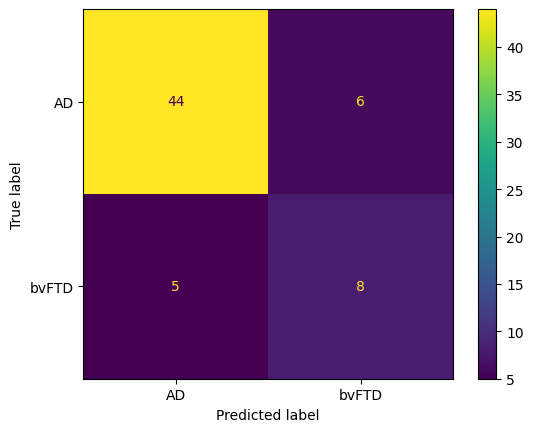

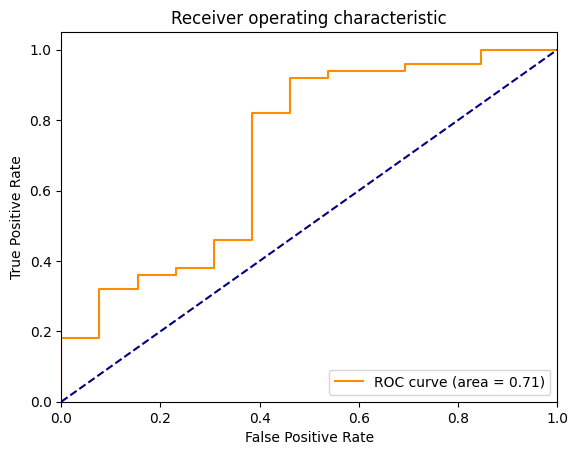

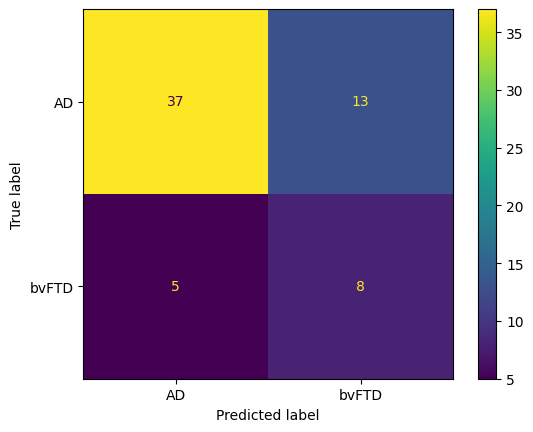

In [36]:
# df = all_samples_w[all_samples_w['grp'].isin(['AD','bvFTD'])]
df = sample_w_multi[sample_w_multi['grp_vol'].isin(['AD','bvFTD'])]
df = df.reset_index(drop=True)
X = df
# y = df['grp']
y = df['grp_vol']

#Stratified 10fold cross validation
skf = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
skf.get_n_splits(X, y)


for i, (train_index, test_index) in enumerate(skf.split(X, y)):
  print(f"Fold {i}:")
  X_train = X.iloc[train_index]
  y_train = y.iloc[train_index]
  X_test  = X.iloc[test_index]
  y_test  = y.iloc[test_index]

  #Create the data-frames with ''mean w-scores values'' for each ROI (FROM THE TRAIN SET)
  AD_w = X_train[X_train['grp_vol']=='AD'][ROI_list_].mean().to_list()
  bvFTD_w = X_train[X_train['grp_vol']=='bvFTD'][ROI_list_].mean().to_list()

  #This dataFrame stores the mean w-scores for all ROIs (parent+child)
  df_mean_sim = pd.DataFrame(columns = columns)
  row3 = pd.Series( ['AD']    + AD_w  ,index=columns)
  row4 = pd.Series( ['bvFTD'] + bvFTD_w, index=columns)
  df_mean_sim = pd.concat([df_mean_sim, row3.to_frame().T], ignore_index=True)
  df_mean_sim = pd.concat([df_mean_sim, row4.to_frame().T], ignore_index=True)



  #creating output dataframe for interpretation (ON THE TEST TEST)
  templist = X_test.columns[1:4].to_list()
  X_test = X_test[templist + ROI_list_].dropna() #Corrected line
  df_sim = X_test[templist].copy()    #Copies the metadata, i.e., first 4 columns into another df
  y_test = X_test['grp_vol']


  #ROIs_chosen {100Children, 24parent, 124parents+children, or the lobes}
  sim_mat = cosine_similarity(X_test[ROI_list_], df_mean_sim[ROI_list_])
  df_sim['sim_AD_mean']  = sim_mat[:,0]
  df_sim['sim_bvFTD_mean']  = sim_mat[:,1]
  df_sim["uid"] = df_sim["sample"] + "_" + df_sim["sid"]
  df_sim["DSI"] = df_sim["sim_AD_mean"] - df_sim["sim_bvFTD_mean"]                  #DSI: DiseaseSimilarityIndex
  df_sim["binary_DSI"] = return_label(df_sim)


  scores = df_sim['DSI']
  fpr, tpr, thresholds = metrics.roc_curve(y_test, scores, pos_label ='AD')     #1:AD   0:bvFTD
  print(len(fpr))
  roc_auc = AUC(fpr, tpr, i)

  cm = confusion_matrix(df_sim['grp_vol'],
                      df_sim['binary_DSI'])
  print(cm)
  disp = ConfusionMatrixDisplay(confusion_matrix= cm,  display_labels=['AD','bvFTD'] )

  disp.plot()
  disp.figure_.savefig('Fold{}_ConfusionMatrix.png'.format(i))

  metric_obj = get_values(cm)

  row=  pd.Series({'fold': int(i),
        'auc': roc_auc,
        'bacc': metric_obj[0],
        'sen':  metric_obj[1],
        'spec': metric_obj[2],
        'ppv':  metric_obj[3],
        'npv':  metric_obj[4],
        'f1':   metric_obj[5],
        'acc':  metric_obj[6]
        })
  df_fold_metrics = pd.concat([df_fold_metrics, row.to_frame().T], ignore_index=True)


In [39]:
df_fold_metrics#.to_csv('temp.csv')

,fold,auc,bacc,sen,spec,ppv,npv,f1,acc
0,0.0,0.823529,0.830882,0.916667,0.745098,0.458333,0.974359,0.611111,0.777778
1,1.0,0.870915,0.838235,0.833333,0.843137,0.555556,0.955556,0.666667,0.841270
2,2.0,0.926471,0.870098,0.916667,0.823529,0.550000,0.976744,0.687500,0.841270
3,3.0,0.890769,0.737692,0.615385,0.860000,0.533333,0.895833,0.571429,0.809524
4,4.0,0.838462,0.727692,0.615385,0.840000,0.500000,0.893617,0.551724,0.793651
5,5.0,0.873846,0.804615,0.769231,0.840000,0.555556,0.933333,0.645161,0.825397
6,6.0,0.918462,0.851538,0.923077,0.780000,0.521739,0.975000,0.666667,0.809524
7,7.0,0.718462,0.696154,0.692308,0.700000,0.375000,0.897436,0.486486,0.698413
8,8.0,0.776923,0.747692,0.615385,0.880000,0.571429,0.897959,0.592593,0.825397
9,9.0,0.710769,0.677692,0.615385,0.740000,0.380952,0.880952,0.470588,0.714286


In [40]:
df_fold_metrics.mean().round(2)     #Mean metrics, across 10 folds

,0
fold,4.50
auc,0.83
bacc,0.78
sen,0.75
spec,0.81
ppv,0.50
npv,0.93
f1,0.59
acc,0.79


In [41]:
df_fold_metrics.std().round(2)     #standard deviation of the metrics, across 10 folds

,0
fold,3.03
auc,0.08
bacc,0.07
sen,0.14
spec,0.06
ppv,0.07
npv,0.04
f1,0.08
acc,0.05
